## SFC Meteorology Obs from:
** - 2018 St Matt's (MTITAEPR-1A) **   
** - 2018 M2 (BSITAEPR-2A) **   
*** - 2018 M2 (BSM-2A) ***

__pyversion__==3.6   
__author__==S.Bell

In [1]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2018-08-21 13:06:18.383636


### connecting to erddap and retrieving and basic information

In [2]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

/Users/bell/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bell/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='a_met'))

In [4]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 3 tabledap, 0 griddap, and 0 wms endpoints.'

In [5]:
datasets = df['Dataset ID'].values
print(datasets)

['erddap_17ckitaem2a_met' 'erddap_18bsitaepr2a_met'
 'erddap_18mtitaepr1a_met']


In [6]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in datasets]
print(variables)

[['wind_speed', 'time', 'eastward_wind', 'latitude', 'air_temperature', 'longitude', 'relative_humidity', 'air_pressure', 'wind_from_direction', 'northward_wind'], ['wind_speed', 'time', 'eastward_wind', 'latitude', 'air_temperature', 'longitude', 'relative_humidity', 'air_pressure', 'wind_from_direction', 'northward_wind'], ['wind_speed', 'time', 'eastward_wind', 'latitude', 'air_temperature', 'longitude', 'relative_humidity', 'air_pressure', 'wind_from_direction', 'northward_wind']]


### getting Peggy Buoy (BSM-2A) Data

In [7]:
wdf = pd.read_csv('http://pavlof.pmel.noaa.gov/bell/ArgosMooring/TotalArgosMessage_28882.csv',
                  parse_dates=True,index_col='sampletime')

In [8]:
wdf = wdf.resample('1H').mean()

### retrieving erddap and plotting data

In [9]:
constraints = {
    'time>=': '2017-07-10T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = [
 'wind_from_direction', 
 'air_temperature',
 'relative_humidity',
 'northward_wind', 
 'eastward_wind', 
 'wind_speed', 
 'latitude',
 'longitude',
 'time'
]

variable_dic={}

for index,row in df.iterrows():
    info_url = e.get_info_url(dataset_id=row['Dataset ID'], response='csv')
    info = pd.read_csv(info_url)

    #print(info.head())
    print('Variables in {}:'.format(row['Dataset ID']))
    print(','.join(info.loc[info['Row Type'] == 'variable', 'Variable Name']))

    variable_dic.update({row['Dataset ID']:list(info.loc[info['Row Type'] == 'variable', 'Variable Name'])})
    

Variables in erddap_17ckitaem2a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_18bsitaepr2a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_18mtitaepr1a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind


In [10]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in ['erddap_18bsitaepr2a_met','erddap_18mtitaepr1a_met']:
        print(row['Dataset ID'])
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            if row['Dataset ID'] in ['erddap_18bsitaepr2a_met']:
                e.variables=variables + ['air_pressure']
            elif row['Dataset ID'] in ['erddap_18mtitaepr1a_met']:
                e.variables=variables + ['air_pressure']
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})
    

erddap_18bsitaepr2a_met
erddap_18mtitaepr1a_met


### Take care of any preliminary QC

In [11]:
#eliminate unlikely wind and pressure extremes
for ds, df in dfs.items():
    df.wind_speed[df.wind_speed>100] = np.nan
    df.air_pressure[df.air_pressure<940] = np.nan
    
#Arbitrary QC points based on evaluating plot / local characteristics and not broad science boundaries
wdf.WS[wdf.WS>25] = np.nan
wdf.RH[wdf.RH<25] = np.nan
wdf.BP[wdf.BP<975] = np.nan

### Plot

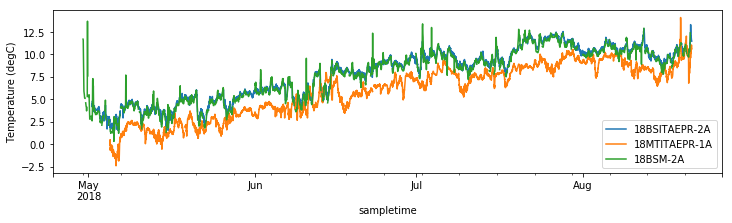

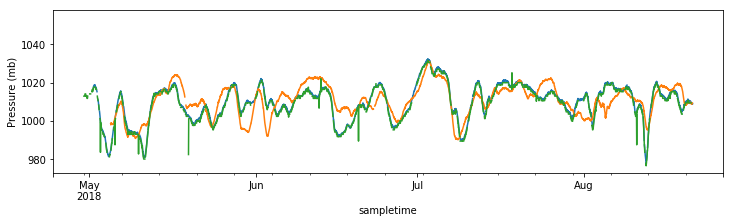

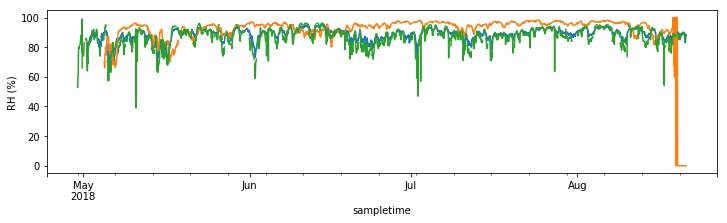

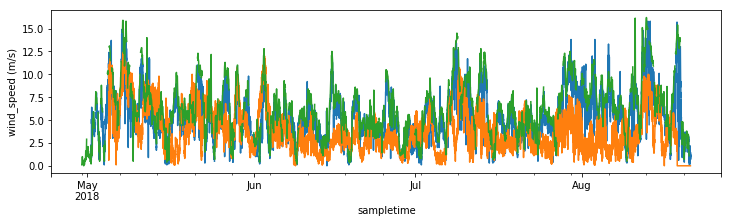

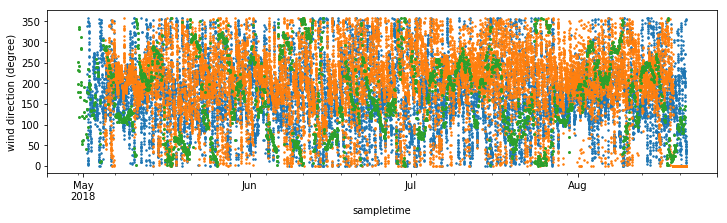

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df.air_temperature.plot(ax=ax)
        plt.ylabel('Temperature (degC)')
    except:
        pass
wdf.AT.plot(ax=ax)
plt.legend(['18BSITAEPR-2A','18MTITAEPR-1A','18BSM-2A'])

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df.air_pressure_at_sealevel.plot(ax=ax)
        plt.ylabel('Pressure (mb)')
    except:
        df.air_pressure.plot(ax=ax)
        plt.ylabel('Pressure (mb)')
wdf.BP.plot(ax=ax)

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df.relative_humidity.plot(ax=ax)
        plt.ylabel('RH (%)')
    except:
        pass
wdf.RH.plot(ax=ax)
    
fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df.wind_speed.plot(ax=ax)
        plt.ylabel('wind_speed (m/s)')
    except:
        pass
wdf.WS.plot(ax=ax)

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df.wind_from_direction.plot(style='.',markersize=3.0,ax=ax)
        plt.ylabel('wind direction (degree)')
    except:
        pass
wdf.WD.plot(style='.',markersize=4.0,ax=ax)
    

In [13]:
wdf.tail()

,argosid,latitude,longitude,BP,AT,BV,RH,WS,WD,SR,AZ
sampletime,,,,,,,,,,,
2018-08-20 19:00:00,28882.0,56.863,164.0645,1009.411765,10.4,12.0,89.0,3.4,114.358323,181.179313,271.071580
2018-08-20 20:00:00,28882.0,56.858,164.0545,1009.411765,10.3,12.0,89.0,3.3,112.946492,241.572417,271.071580
2018-08-20 21:00:00,28882.0,56.857,164.0655,1009.411765,10.6,12.0,89.0,2.1,138.359452,439.222576,271.071580
2018-08-20 22:00:00,28882.0,56.857,164.0655,1009.411765,11.4,12.0,87.0,1.4,144.006777,675.304711,271.071580
2018-08-20 23:00:00,28882.0,56.855,164.0740,1009.411765,12.4,NaN,84.0,1.1,118.593816,581.969913,272.483411


In [14]:
df.tail()

,wind_from_direction,air_temperature,relative_humidity,northward_wind,eastward_wind,wind_speed,latitude,longitude,air_pressure
time,,,,,,,,,
2018-08-21 03:50:00,0.0,10.68,0.0,0.0,0.0,0.0,60.026,187.21,1009.27
2018-08-21 04:00:00,0.0,10.51,0.0,0.0,0.0,0.0,60.026,187.21,1009.29
2018-08-21 04:10:00,0.0,10.61,0.0,0.0,0.0,0.0,60.026,187.21,1009.36
2018-08-21 04:20:00,0.0,11.05,0.0,0.0,0.0,0.0,60.026,187.21,1009.39
2018-08-21 04:30:00,0.0,10.66,0.0,0.0,0.0,0.0,60.026,187.21,1009.37


### Next Steps

**TODO:** Plot top prawler bin/air temp for a SST/Air analysis